# Worksheet 10 — Naive Bayes (Text Classification) & Feature Selection (RFE)

Install Required Libraries

In [31]:
!pip install -q scikit-learn nltk pandas matplotlib joblib

Mount Drive & load CSV

In [32]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Concept and Technology of AI/IMDB_Dataset.csv')

print("Dataset shape:", df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Imports & NLTK setup

In [33]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# NLTK for stopwords and stemming
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

# small helper for plotting ROC
def plot_roc(y_true, y_proba, title='ROC Curve'):
    try:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc = roc_auc_score(y_true, y_proba)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
        plt.plot([0,1],[0,1], '--', color='gray')
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title(title); plt.legend(); plt.grid(True); plt.show()
    except Exception as e:
        print("Could not compute ROC:", e)

Text preprocessing function  exact & reproducible

In [34]:
def preprocess_text(text):
    """
    1) Lowercase
    2) Remove HTML tags (simple)
    3) Keep alphabets and whitespace, remove numbers/punct
    4) Tokenize, remove stopwords, apply Porter stemming
    """
    if pd.isna(text):
        return ""
    s = str(text).lower()

    # remove simple HTML tags
    s = re.sub(r'<[^>]+>', ' ', s)

    # keep letters and whitespace
    s = re.sub('[^a-z\\s]', ' ', s)
    tokens = [w for w in s.split() if w not in stop_words and len(w) > 1]
    stems = [ps.stem(w) for w in tokens]
    return ' '.join(stems)

Validate dataset columns & map labels

In [35]:
# Expecting columns: 'review' and 'sentiment' in dataset
print("Columns present:", list(df.columns))

# Map sentiment to binary 0/1
df['sentiment'] = df['sentiment'].map(lambda x: 1 if str(x).strip().lower() in ('positive','pos','1','true','t') else 0)
print("After mapping, unique sentiments:", df['sentiment'].unique())
display(df.head(3))

Columns present: ['review', 'sentiment']
After mapping, unique sentiments: [1 0]


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1


Preprocess all reviews.

In [36]:
# Shows progress in batches to keep the UI responsive.
from tqdm import tqdm
tqdm.pandas()

print("Preprocessing reviews ...")
df['processed_review'] = df['review'].progress_map(preprocess_text)

# Quick sanity-check
print("Sample processed text:")
display(df[['processed_review','sentiment']].head(4))

Preprocessing reviews ...


100%|██████████| 50000/50000 [02:45<00:00, 302.97it/s]

Sample processed text:


,processed_review,sentiment
0,one review mention watch oz episod hook right ...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0


Train/Test split

In [37]:
X = df['processed_review']
y = df['sentiment'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

Train size: 40000 Test size: 10000


Vectorize: CountVectorizer baseline

In [38]:
# Baseline: Count Vectorizer (BoW).
max_features = 20000  # adjust based on runtime/memory
vectorizer = CountVectorizer(max_features=max_features, ngram_range=(1,1))
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

print("Vocabulary size (actual):", len(vectorizer.get_feature_names_out()))

Vocabulary size (actual): 20000


Train Multinomial Naive Bayes

In [39]:
nb = MultinomialNB()
nb.fit(X_train_bow, y_train)
print("Naive Bayes trained on BoW.")

Naive Bayes trained on BoW.


Evaluate Naive Bayes

TRAIN Accuracy: 0.874
TEST Accuracy : 0.853

Classification report (test):
              precision    recall  f1-score   support

           0     0.8413    0.8702    0.8555      5000
           1     0.8656    0.8358    0.8504      5000

    accuracy                         0.8530     10000
   macro avg     0.8534    0.8530    0.8530     10000
weighted avg     0.8534    0.8530    0.8530     10000


Confusion matrix (test):
[[4351  649]
 [ 821 4179]]

ROC-AUC (test): 0.91901372


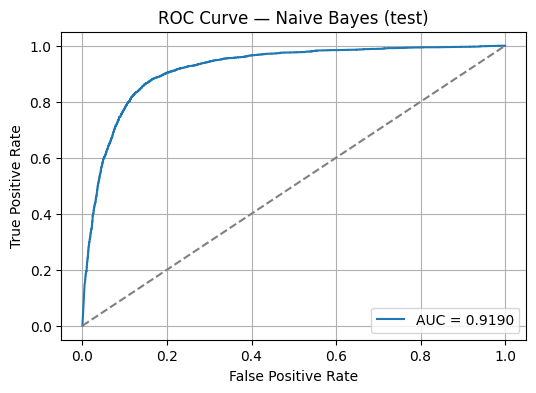

In [40]:
y_train_pred = nb.predict(X_train_bow)
y_test_pred = nb.predict(X_test_bow)
y_test_proba = nb.predict_proba(X_test_bow)[:,1] if hasattr(nb, 'predict_proba') else None

print("TRAIN Accuracy:", accuracy_score(y_train, y_train_pred))
print("TEST Accuracy :", accuracy_score(y_test, y_test_pred))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, digits=4))

print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

if y_test_proba is not None:
    try:
        print("\nROC-AUC (test):", roc_auc_score(y_test, y_test_proba))
        plot_roc(y_test, y_test_proba, title='ROC Curve — Naive Bayes (test)')
    except Exception as e:
        print("ROC error:", e)



















Top informative tokens for each class

In [41]:
# For MultinomialNB, informative features approximated by log(P(word|class))
feature_names = vectorizer.get_feature_names_out()
class_log_prob = nb.feature_log_prob_  # shape [n_classes, n_features]

def show_top_tokens(class_index, top_n=30):
    top_idx = np.argsort(class_log_prob[class_index])[::-1][:top_n]
    return [(feature_names[i], float(class_log_prob[class_index][i])) for i in top_idx]

print("Top tokens for NEGATIVE class (0):")
display(show_top_tokens(0, top_n=25))

print("\nTop tokens for POSITIVE class (1):")
display(show_top_tokens(1, top_n=25))

Top tokens for NEGATIVE class (0):


[('movi', -3.8969103429859953),
 ('film', -4.157278266747218),
 ('one', -4.662221276921347),
 ('like', -4.761739665481549),
 ('make', -5.183921672350301),
 ('even', -5.231591215037236),
 ('time', -5.235736046035113),
 ('get', -5.246132766920017),
 ('watch', -5.256638716221664),
 ('good', -5.261223012643606),
 ('bad', -5.2649894954390835),
 ('charact', -5.296335218220184),
 ('would', -5.3205066375907055),
 ('see', -5.384661105783335),
 ('realli', -5.446757746215551),
 ('look', -5.490967247989168),
 ('scene', -5.526926178376613),
 ('stori', -5.560162870127305),
 ('act', -5.610407284853181),
 ('much', -5.660815673064048),
 ('go', -5.66882071893818),
 ('end', -5.676890363031205),
 ('peopl', -5.7211522461749045),
 ('thing', -5.727257919509613),
 ('could', -5.735680992238722)]


Top tokens for POSITIVE class (1):


[('film', -4.0560852784808485),
 ('movi', -4.189002660480442),
 ('one', -4.645994577614841),
 ('like', -4.978464961889005),
 ('time', -5.1778529848503165),
 ('good', -5.264612114622702),
 ('see', -5.276709534097929),
 ('stori', -5.343557946238846),
 ('charact', -5.350219012654858),
 ('make', -5.369563715942384),
 ('great', -5.422833782709157),
 ('well', -5.428599702969496),
 ('watch', -5.433817610257103),
 ('get', -5.44757191185858),
 ('love', -5.474954515817592),
 ('show', -5.592321223855979),
 ('also', -5.6036233591192275),
 ('realli', -5.615635515567231),
 ('would', -5.633928708614556),
 ('scene', -5.678455783327356),
 ('play', -5.682920076456043),
 ('even', -5.70237228044474),
 ('end', -5.767561543408675),
 ('much', -5.768238087646646),
 ('first', -5.773666982630759)]

### Observations:
- Preprocessing (lowercasing, stopword removal, stemming) reduces noise and vocabulary size.
- Bag-of-Words + Multinomial Naive Bayes is a fast baseline for sentiment analysis.
- Evaluate both accuracy and class-wise metrics (precision/recall/F1). For imbalanced datasets, prefer AUC and F1.
- Inspecting top tokens per class helps diagnose model behavior (e.g., presence of negation or domain words).

# Part 2 — Feature Selection (RFE) with Logistic Regression

We will use the structured **Breast Cancer** dataset (sklearn) for the RFE exercise:
- Apply scaling (StandardScaler)
- Use RFE with LogisticRegression to select top K features (K = 5 by default)
- Compare performance: selected-features model vs all-features model

In [42]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X_bc = pd.DataFrame(data.data, columns=data.feature_names)
y_bc = pd.Series(data.target, name='target')

print("Breast cancer dataset shape:", X_bc.shape)
display(X_bc.head(3))
print("Target distribution:\n", y_bc.value_counts())

Breast cancer dataset shape: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


Target distribution:
 target
1    357
0    212
Name: count, dtype: int64


Train/test split and scaling

In [43]:
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(
    X_bc, y_bc, test_size=0.20, random_state=42, stratify=y_bc
)

scaler = StandardScaler()
X_train_bc_scaled = scaler.fit_transform(X_train_bc)
X_test_bc_scaled = scaler.transform(X_test_bc)

print("Training samples:", X_train_bc.shape[0], "Test samples:", X_test_bc.shape[0])

Training samples: 455 Test samples: 114


RFE: select top K features

In [44]:
k = 5  # top features to select
logreg = LogisticRegression(max_iter=10000)
rfe = RFE(estimator=logreg, n_features_to_select=k)
rfe.fit(X_train_bc_scaled, y_train_bc)

selected_idx = np.where(rfe.support_)[0]
selected_features = X_bc.columns[selected_idx].tolist()
print(f"Top {k} features selected by RFE:")
display(selected_features)

# Feature ranking
ranking = pd.Series(rfe.ranking_, index=X_bc.columns).sort_values()
print("\nFeature ranking (1 = selected):")
display(ranking.head(20))

Top 5 features selected by RFE:


['radius error',
 'worst radius',
 'worst texture',
 'worst area',
 'worst concave points']


Feature ranking (1 = selected):


,0
radius error,1
worst radius,1
worst area,1
worst texture,1
worst concave points,1
worst perimeter,2
area error,3
worst smoothness,4
mean area,5
worst concavity,6


Train & evaluate LogisticRegression on selected features

Selected-features model (test) metrics:
Accuracy: 0.9473684210526315
              precision    recall  f1-score   support

           0     0.9286    0.9286    0.9286        42
           1     0.9583    0.9583    0.9583        72

    accuracy                         0.9474       114
   macro avg     0.9435    0.9435    0.9435       114
weighted avg     0.9474    0.9474    0.9474       114

ROC-AUC: 0.9947089947089948


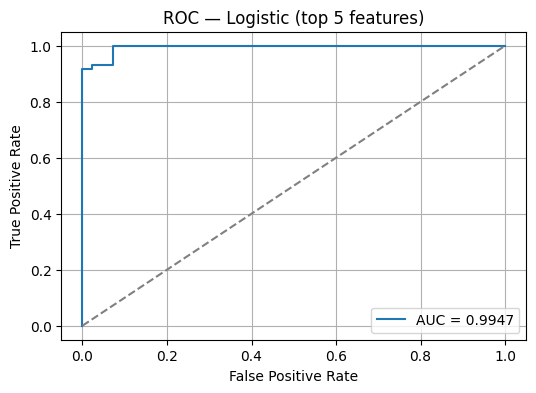

In [45]:
# Prepare selected features subset
X_train_sel = X_train_bc.iloc[:, selected_idx]
X_test_sel  = X_test_bc.iloc[:, selected_idx]

scaler_sel = StandardScaler()
X_train_sel_s = scaler_sel.fit_transform(X_train_sel)
X_test_sel_s  = scaler_sel.transform(X_test_sel)

logreg_sel = LogisticRegression(max_iter=10000)
logreg_sel.fit(X_train_sel_s, y_train_bc)

y_pred_sel = logreg_sel.predict(X_test_sel_s)
y_proba_sel = logreg_sel.predict_proba(X_test_sel_s)[:,1]

print("Selected-features model (test) metrics:")
print("Accuracy:", accuracy_score(y_test_bc, y_pred_sel))
print(classification_report(y_test_bc, y_pred_sel, digits=4))
print("ROC-AUC:", roc_auc_score(y_test_bc, y_proba_sel))
plot_roc(y_test_bc, y_proba_sel, title=f'ROC — Logistic (top {k} features)')

Train & evaluate LogisticRegression on ALL features

All-features model (test) metrics:
Accuracy: 0.9824561403508771
              precision    recall  f1-score   support

           0     0.9762    0.9762    0.9762        42
           1     0.9861    0.9861    0.9861        72

    accuracy                         0.9825       114
   macro avg     0.9812    0.9812    0.9812       114
weighted avg     0.9825    0.9825    0.9825       114

ROC-AUC: 0.9953703703703703


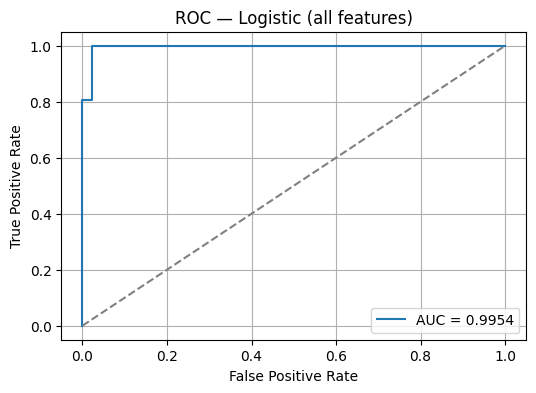

In [46]:
logreg_all = LogisticRegression(max_iter=10000)
logreg_all.fit(X_train_bc_scaled, y_train_bc)

y_pred_all = logreg_all.predict(X_test_bc_scaled)
y_proba_all = logreg_all.predict_proba(X_test_bc_scaled)[:,1]

print("All-features model (test) metrics:")
print("Accuracy:", accuracy_score(y_test_bc, y_pred_all))
print(classification_report(y_test_bc, y_pred_all, digits=4))
print("ROC-AUC:", roc_auc_score(y_test_bc, y_proba_all))
plot_roc(y_test_bc, y_proba_all, title='ROC — Logistic (all features)')






























Experiment: try k = 3,5,7 and summarize

In [47]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

for k in [3, 5, 7]:
    print(f"\n--- RFE with k = {k} features ---")

    # RFE with Logistic Regression
    rfe_k = RFE(
        estimator=LogisticRegression(max_iter=10000),
        n_features_to_select=k
    )
    rfe_k.fit(X_train_bc, y_train_bc)

    # Selected feature indices
    idx_k = np.where(rfe_k.support_)[0]

    # Select features
    X_train_k = X_train_bc.iloc[:, idx_k]
    X_test_k  = X_test_bc.iloc[:, idx_k]

    # IMPORTANT: fit scaler again for this feature subset
    scaler_k = StandardScaler()
    X_train_k_scaled = scaler_k.fit_transform(X_train_k)
    X_test_k_scaled  = scaler_k.transform(X_test_k)

    # Train model
    model_k = LogisticRegression(max_iter=10000)
    model_k.fit(X_train_k_scaled, y_train_bc)

    # Evaluate
    y_pred_k = model_k.predict(X_test_k_scaled)
    acc = accuracy_score(y_test_bc, y_pred_k)

    print("Selected features:")
    print(list(X_train_k.columns))
    print("Test Accuracy:", acc)


--- RFE with k = 3 features ---
Selected features:
['texture error', 'worst compactness', 'worst concavity']
Test Accuracy: 0.8070175438596491

--- RFE with k = 5 features ---
Selected features:
['mean radius', 'texture error', 'worst radius', 'worst compactness', 'worst concavity']
Test Accuracy: 0.9385964912280702

--- RFE with k = 7 features ---
Selected features:
['mean radius', 'texture error', 'worst radius', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry']
Test Accuracy: 0.9649122807017544


## Worksheet 10 — Final Notes & Submission Checklist

**What has been done:**
- Used the Kaggle IMDB movie reviews dataset for Naive Bayes text classification.
- Performed preprocessing (HTML removal, non-letter removal, stopwords, stemming).
- Vectorized text (CountVectorizer) and trained MultinomialNB.
- Evaluated using accuracy, precision/recall/F1, confusion matrix, ROC-AUC.
- For feature selection, used sklearn's Breast Cancer dataset and applied RFE + Logistic Regression.
- Compared model trained on selected features vs. all features and saved artifacts.